<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_LSTM/GRU_LSTM_GBPUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 4.62 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 19 15:55:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'GBPUSD'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 14.8MB/s 
     |████████████████████████████████| 143kB 53.5MB/s 
     |████████████████████████████████| 143kB 55.7MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 174kB 51.4MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(GRU(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: aniifh0c
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_LSTM/sweeps/aniifh0c


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: bs117qhu with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
8/8 [==============================] - 24s 258ms/step - loss: 0.3162 - mean_squared_error: 0.3162 - mean_absolute_error: 0.4740 - val_loss: 0.1090 - val_mean_squared_error: 0.1090 - val_mean_absolute_error: 0.2629
Epoch 2/200
8/8 [==============================] - 1s 113ms/step - loss: 0.0914 - mean_squared_error: 0.0914 - mean_absolute_error: 0.2341 - val_loss: 0.0497 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.2094
Epoch 3/200
8/8 [==============================] - 1s 97ms/step - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1549 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0899
Epoch 4/200
8/8 [==============================] - 1s 103ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.1128 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0789
Epoch 5/200
8/8 [==============================] - 1s 96ms/step - loss: 0.0092 - mean_squared_error:

epoch,122
loss,0.00219
mean_squared_error,0.00219
mean_absolute_error,0.03493
val_loss,0.00373
val_mean_squared_error,0.00373
val_mean_absolute_error,0.04776
_runtime,139
_timestamp,1626710330
_step,122
best_val_loss,0.00352


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u2xd97zd with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 222ms/step - loss: 0.2442 - mean_squared_error: 0.2442 - mean_absolute_error: 0.4092 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0530
Epoch 2/100
8/8 [==============================] - 1s 105ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0546 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0467
Epoch 3/100
8/8 [==============================] - 1s 104ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0518 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0806
Epoch 4/100
8/8 [==============================] - 1s 98ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0774 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0451
Epoch 5/100
8/8 [==============================] - 1s 105ms/step - loss: 0.0025 - mean_squared_error:

epoch,99
loss,0.0015
mean_squared_error,0.0015
mean_absolute_error,0.02913
val_loss,0.00144
val_mean_squared_error,0.00144
val_mean_absolute_error,0.02949
_runtime,98
_timestamp,1626710440
_step,99
best_val_loss,0.00143


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▇▂█▂▂▂▂▃▂▅▄▂▂▂▁▃▁▂▁▁▂▁▂▁▁▂▁▁▂▁▂▂▁▂▁▂▁▁▁
val_mean_squared_error,▃▇▂█▂▂▂▂▃▂▅▄▂▂▂▁▃▁▂▁▁▂▁▂▁▁▂▁▁▂▁▂▂▁▂▁▂▁▁▁
val_mean_absolute_error,▄▇▃█▃▂▃▂▄▂▅▄▂▂▃▂▄▂▂▂▁▂▂▂▂▁▂▂▁▃▂▂▂▁▂▁▃▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2nnm8pn1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 7s 130ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - mean_absolute_error: 0.2013 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0557
Epoch 2/200
32/32 [==============================] - 3s 102ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0554 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0511
Epoch 3/200
32/32 [==============================] - 3s 105ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0437 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0533
Epoch 4/200
32/32 [==============================] - 3s 108ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0434 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0475
Epoch 5/200
32/32 [==============================] - 4s 113ms/step - loss: 0.0024 - mean_squ

epoch,107
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02143
val_loss,0.00132
val_mean_squared_error,0.00132
val_mean_absolute_error,0.02826
_runtime,380
_timestamp,1626710830
_step,107
best_val_loss,0.00132


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▄▃▃▃▃▂▂▃▂▃▂▄▂▂▂▁▁▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▄▃▄▃▃▃▃▂▂▃▂▃▂▄▂▂▂▁▁▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▅▄▅▄▃▃▃▃▃▃▂▃▂▄▂▂▂▂▂▂▃▂▁▂▁▂▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: m9l5e5h7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 7s 129ms/step - loss: 0.1270 - mean_squared_error: 0.1270 - mean_absolute_error: 0.2600 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0614
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0786 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0657
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0557 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0559
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0550 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0576
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0027 - mean_squared_error: 0.

epoch,170
loss,0.00073
mean_squared_error,0.00073
mean_absolute_error,0.02025
val_loss,0.00137
val_mean_squared_error,0.00137
val_mean_absolute_error,0.02863
_runtime,28
_timestamp,1626710869
_step,170
best_val_loss,0.00132


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8ip10qtz with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 6s 231ms/step - loss: 0.5412 - mean_squared_error: 0.5412 - mean_absolute_error: 0.5526 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0792
Epoch 2/50
8/8 [==============================] - 1s 108ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0737 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0507
Epoch 3/50
8/8 [==============================] - 1s 112ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0507 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0485
Epoch 4/50
8/8 [==============================] - 1s 107ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0433 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0455
Epoch 5/50
8/8 [==============================] - 1s 107ms/step - loss: 0.0034 - mean_squared_error: 0.0

epoch,49
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.03498
val_loss,0.00325
val_mean_squared_error,0.00325
val_mean_absolute_error,0.04603
_runtime,55
_timestamp,1626710935
_step,49
best_val_loss,0.00168


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▄▂▂▂▂▄▅▂▃▂▂▁▂▁▃▂▂▂▃▁▃▁▁▂▂▂▁▂▁▂▁▁▁▁▃▂
val_mean_squared_error,█▃▂▂▄▂▂▂▂▄▅▂▃▂▂▁▂▁▃▂▂▂▃▁▃▁▁▂▂▂▁▂▁▂▁▁▁▁▃▂
val_mean_absolute_error,█▄▃▃▅▃▃▃▃▅▆▂▄▂▂▂▃▂▄▂▂▃▄▂▄▁▁▃▂▃▂▂▁▃▁▂▁▁▄▃
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: a4qva2td with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 5s 36ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1120 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0486
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0433 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0418
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0383 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0404
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0345 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0490
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_erro

epoch,40
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.02365
val_loss,0.0015
val_mean_squared_error,0.0015
val_mean_absolute_error,0.03017
_runtime,20
_timestamp,1626711001
_step,40
best_val_loss,0.00143


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▃▂▃▂▂▂▂▁▂▂▂▂▁▂▂▂▂▁▁▁▁▂▁▂▁▁▁▂▂▁▁▁▁▁
val_loss,█▅▄█▄▅▆▃▅▃▃▃▂▂▂▂▃▂▂▂▂▂▁▁▁▂▁▃▂▁▁▁▁▂▁▁▁▄▂▁
val_mean_squared_error,█▅▄█▄▅▆▃▅▃▃▃▂▂▂▂▃▂▂▂▂▂▁▁▁▂▁▃▂▁▁▁▁▂▁▁▁▄▂▁
val_mean_absolute_error,█▅▅█▄▆▆▃▆▃▄▃▃▂▃▃▄▃▂▂▂▂▂▂▂▂▂▄▂▁▁▁▁▂▂▁▁▄▂▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: evp4nvje with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 33ms/step - loss: 0.1314 - mean_squared_error: 0.1314 - mean_absolute_error: 0.2698 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0711
Epoch 2/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0622 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0556
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0423 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0543
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0377 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0533
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_erro

epoch,199
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.0214
val_loss,0.00137
val_mean_squared_error,0.00137
val_mean_absolute_error,0.0287
_runtime,68
_timestamp,1626711080
_step,199
best_val_loss,0.00136


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▆▅▆▅▅▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇█▆▅▆▅▅▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cdbmn7wh with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 5s 237ms/step - loss: 0.1852 - mean_squared_error: 0.1852 - mean_absolute_error: 0.3460 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1440
Epoch 2/200
8/8 [==============================] - 1s 113ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - mean_absolute_error: 0.1907 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1084
Epoch 3/200
8/8 [==============================] - 1s 111ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.1206 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0781
Epoch 4/200
8/8 [==============================] - 1s 110ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0902 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0742
Epoch 5/200
8/8 [==============================] - 1s 106ms/step - loss: 0.0073 - mean_squared_error

epoch,71
loss,0.00226
mean_squared_error,0.00226
mean_absolute_error,0.03529
val_loss,0.00318
val_mean_squared_error,0.00318
val_mean_absolute_error,0.04503
_runtime,76
_timestamp,1626711189
_step,71
best_val_loss,0.00293


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ocwa1aou with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 9s 137ms/step - loss: 0.1247 - mean_squared_error: 0.1247 - mean_absolute_error: 0.2533 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0585
Epoch 2/200
32/32 [==============================] - 3s 107ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0452 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0549
Epoch 3/200
32/32 [==============================] - 4s 112ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0468 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0539
Epoch 4/200
32/32 [==============================] - 3s 106ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0432 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0693
Epoch 5/200
32/32 [==============================] - 3s 106ms/step - loss: 0.0032 - mean_squ

epoch,75
loss,0.00146
mean_squared_error,0.00146
mean_absolute_error,0.02818
val_loss,0.00208
val_mean_squared_error,0.00208
val_mean_absolute_error,0.03582
_runtime,282
_timestamp,1626711493
_step,75
best_val_loss,0.00207


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄█▄▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▁▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▄█▄▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▁▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▅█▅▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8ia9ryxo with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 6s 168ms/step - loss: 52.3166 - mean_squared_error: 52.3166 - mean_absolute_error: 2.8167 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0959
Epoch 2/50
16/16 [==============================] - 2s 116ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1426 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1677
Epoch 3/50
16/16 [==============================] - 2s 114ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1588 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1178
Epoch 4/50
16/16 [==============================] - 2s 112ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1635 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1418
Epoch 5/50
16/16 [==============================] - 2s 113ms/step - loss: 0.0401 - mean_square

epoch,37
loss,0.00335
mean_squared_error,0.00335
mean_absolute_error,0.04458
val_loss,0.00219
val_mean_squared_error,0.00219
val_mean_absolute_error,0.03802
_runtime,76
_timestamp,1626711627
_step,37
best_val_loss,0.00169


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▃▂▂█▁▁▁█▂▁▃▂▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▃▂▂█▁▁▁█▂▁▃▂▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▄▃▄█▂▁▂█▃▁▅▂▃▁▂▂▁▁▂▁▂▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ivpxszpo with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 6s 251ms/step - loss: 0.3134 - mean_squared_error: 0.3134 - mean_absolute_error: 0.4749 - val_loss: 0.1840 - val_mean_squared_error: 0.1840 - val_mean_absolute_error: 0.3610
Epoch 2/200
8/8 [==============================] - 1s 106ms/step - loss: 0.2134 - mean_squared_error: 0.2134 - mean_absolute_error: 0.3834 - val_loss: 0.1051 - val_mean_squared_error: 0.1051 - val_mean_absolute_error: 0.2598
Epoch 3/200
8/8 [==============================] - 1s 108ms/step - loss: 0.1088 - mean_squared_error: 0.1088 - mean_absolute_error: 0.2637 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0970
Epoch 4/200
8/8 [==============================] - 1s 116ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1168 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1202
Epoch 5/200
8/8 [==============================] - 1s 112ms/step - loss: 0.0136 - mean_squared_error

epoch,130
loss,0.00216
mean_squared_error,0.00216
mean_absolute_error,0.03483
val_loss,0.00359
val_mean_squared_error,0.00359
val_mean_absolute_error,0.04715
_runtime,133
_timestamp,1626711782
_step,130
best_val_loss,0.00327


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: arfwkd9e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 4s 34ms/step - loss: 0.4184 - mean_squared_error: 0.4184 - mean_absolute_error: 0.3753 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0473
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0830 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1669
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0990 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0881
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0937 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0806
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_erro

epoch,27
loss,0.00212
mean_squared_error,0.00212
mean_absolute_error,0.03563
val_loss,0.00226
val_mean_squared_error,0.00226
val_mean_absolute_error,0.03811
_runtime,17
_timestamp,1626711825
_step,27
best_val_loss,0.00147


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁█▃▂▁▁▃▅▁▁▂▃▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,▁█▃▂▁▁▃▅▁▁▂▃▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,▂█▄▄▁▁▄▆▁▂▂▄▁▁▂▂▃▁▁▁▁▁▂▃▁▂▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: d073mvgl with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 5s 237ms/step - loss: 0.2959 - mean_squared_error: 0.2959 - mean_absolute_error: 0.4583 - val_loss: 0.1434 - val_mean_squared_error: 0.1434 - val_mean_absolute_error: 0.3105
Epoch 2/200
8/8 [==============================] - 1s 115ms/step - loss: 0.1303 - mean_squared_error: 0.1303 - mean_absolute_error: 0.2823 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0813
Epoch 3/200
8/8 [==============================] - 1s 111ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0758 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0623
Epoch 4/200
8/8 [==============================] - 1s 112ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0574 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0588
Epoch 5/200
8/8 [==============================] - 1s 118ms/step - loss: 0.0047 - mean_squared_error

epoch,85
loss,0.00219
mean_squared_error,0.00219
mean_absolute_error,0.03522
val_loss,0.00279
val_mean_squared_error,0.00279
val_mean_absolute_error,0.04197
_runtime,90
_timestamp,1626711928
_step,85
best_val_loss,0.00276


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: e795dumb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 7s 172ms/step - loss: 0.1412 - mean_squared_error: 0.1412 - mean_absolute_error: 0.2801 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0732
Epoch 2/50
16/16 [==============================] - 2s 109ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0874 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0599
Epoch 3/50
16/16 [==============================] - 2s 110ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0518 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0687
Epoch 4/50
16/16 [==============================] - 2s 111ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0660 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0695
Epoch 5/50
16/16 [==============================] - 2s 113ms/step - loss: 0.0085 - mean_squared_

epoch,49
loss,0.00176
mean_squared_error,0.00176
mean_absolute_error,0.03138
val_loss,0.0022
val_mean_squared_error,0.0022
val_mean_absolute_error,0.03724
_runtime,104
_timestamp,1626712043
_step,49
best_val_loss,0.0022


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▄▄▂▃█▂▃▄▁▁▁▂▂▂▁▂▂▁▁▁▂▂▂▁▁▁▂▁▁▁▁▃▁▁▁▁▁▁
val_mean_squared_error,▄▃▄▄▂▃█▂▃▄▁▁▁▂▂▂▁▂▂▁▁▁▂▂▂▁▁▁▂▁▁▁▁▃▁▁▁▁▁▁
val_mean_absolute_error,▅▃▄▄▃▄█▂▃▄▂▂▂▂▃▂▁▂▂▂▁▁▂▂▃▂▁▁▂▁▁▂▂▄▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 80sfqyfu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 5s 227ms/step - loss: 0.4091 - mean_squared_error: 0.4091 - mean_absolute_error: 0.4819 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0941
Epoch 2/200
8/8 [==============================] - 1s 121ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0911 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0576
Epoch 3/200
8/8 [==============================] - 1s 108ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0576 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0457
Epoch 4/200
8/8 [==============================] - 1s 111ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0495 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0437
Epoch 5/200
8/8 [==============================] - 1s 116ms/step - loss: 0.0034 - mean_squared_error

epoch,133
loss,0.00093
mean_squared_error,0.00093
mean_absolute_error,0.02322
val_loss,0.00149
val_mean_squared_error,0.00149
val_mean_absolute_error,0.02992
_runtime,136
_timestamp,1626712192
_step,133
best_val_loss,0.00139


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▄▃▃▄▃▄▃▂▂▃▂▂▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xijb9gws with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 6s 227ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1269 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0655
Epoch 2/100
8/8 [==============================] - 1s 110ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0823 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0743
Epoch 3/100
8/8 [==============================] - 1s 114ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0702 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0655
Epoch 4/100
8/8 [==============================] - 1s 109ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0534 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0586
Epoch 5/100
8/8 [==============================] - 1s 113ms/step - loss: 0.0050 - mean_squared_error

epoch,99
loss,0.00134
mean_squared_error,0.00134
mean_absolute_error,0.02736
val_loss,0.00246
val_mean_squared_error,0.00246
val_mean_absolute_error,0.03976
_runtime,106
_timestamp,1626712311
_step,99
best_val_loss,0.00221


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅█▅▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▅█▅▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▆█▅▄▃▃▃▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fpvb41yd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 139ms/step - loss: 0.1880 - mean_squared_error: 0.1880 - mean_absolute_error: 0.3481 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0934
Epoch 2/50
32/32 [==============================] - 3s 107ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0853 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0635
Epoch 3/50
32/32 [==============================] - 4s 112ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0483 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0566
Epoch 4/50
32/32 [==============================] - 4s 111ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0455 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0565
Epoch 5/50
32/32 [==============================] - 4s 114ms/step - loss: 0.0033 - mean_squared_

epoch,49
loss,0.00182
mean_squared_error,0.00182
mean_absolute_error,0.03157
val_loss,0.00242
val_mean_squared_error,0.00242
val_mean_absolute_error,0.0393
_runtime,195
_timestamp,1626712521
_step,49
best_val_loss,0.00241


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5m8x2st9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 7s 133ms/step - loss: 0.0769 - mean_squared_error: 0.0769 - mean_absolute_error: 0.1872 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0597
Epoch 2/100
32/32 [==============================] - 4s 113ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0529 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0599
Epoch 3/100
32/32 [==============================] - 4s 111ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0455 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0561
Epoch 4/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0447 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0577
Epoch 5/100
32/32 [==============================] - 4s 111ms/step - loss: 0.0036 - mean_squ

epoch,99
loss,0.00128
mean_squared_error,0.00128
mean_absolute_error,0.02583
val_loss,0.0019
val_mean_squared_error,0.0019
val_mean_absolute_error,0.03422
_runtime,378
_timestamp,1626712929
_step,99
best_val_loss,0.00171


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▅▅▄▅▃▃█▃▃▄▃▂▃▃▃▂▂▂▂▃▁▂▂▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▆▅▅▅▄▅▃▃█▃▃▄▃▂▃▃▃▂▂▂▂▃▁▂▂▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,▇▆▆▅▅▅▄▄█▄▄▄▄▃▄▃▃▂▂▂▂▃▂▃▂▂▁▁▁▂▂▂▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: v9yyg798 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 66ms/step - loss: 0.1495 - mean_squared_error: 0.1495 - mean_absolute_error: 0.2862 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0800
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0842 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0768
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0466 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0531
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0511
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.

epoch,49
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.02789
val_loss,0.00284
val_mean_squared_error,0.00284
val_mean_absolute_error,0.0422
_runtime,21
_timestamp,1626712976
_step,49
best_val_loss,0.00256


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: yuo4lzm3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 8s 140ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1243 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0551
Epoch 2/100
32/32 [==============================] - 4s 115ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0670 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0561
Epoch 3/100
32/32 [==============================] - 4s 113ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0497 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0552
Epoch 4/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0517 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0588
Epoch 5/100
32/32 [==============================] - 4s 120ms/step - loss: 0.0043 - mean_squ

epoch,99
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.02441
val_loss,0.00151
val_mean_squared_error,0.00151
val_mean_absolute_error,0.03095
_runtime,384
_timestamp,1626713375
_step,99
best_val_loss,0.0015


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▅▄▄▅▆▄▃▃▃▃▃▃▂▂▂▂▂▂▃▂▂▃▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁
val_mean_squared_error,██▅▅▄▄▅▆▄▃▃▃▃▃▃▂▂▂▂▂▂▃▂▂▃▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁
val_mean_absolute_error,██▆▆▅▅▆▇▅▄▄▄▄▃▃▃▃▃▃▂▃▄▂▂▃▂▂▂▂▂▁▁▂▁▁▁▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4pqjvcec with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 8s 140ms/step - loss: 0.2005 - mean_squared_error: 0.2005 - mean_absolute_error: 0.3364 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0627
Epoch 2/100
32/32 [==============================] - 4s 111ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0604 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0623
Epoch 3/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0491 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0636
Epoch 4/100
32/32 [==============================] - 4s 112ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0473 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0580
Epoch 5/100
32/32 [==============================] - 4s 113ms/step - loss: 0.0041 - mean_squ

epoch,84
loss,0.00163
mean_squared_error,0.00163
mean_absolute_error,0.02946
val_loss,0.00209
val_mean_squared_error,0.00209
val_mean_absolute_error,0.03668
_runtime,322
_timestamp,1626713711
_step,84
best_val_loss,0.00195


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▅▆▅▄▄▃▃▆▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▇█▆▅▆▅▄▄▃▃▆▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▆▆▄▄▄▃▆▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xeuw8321 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 6s 238ms/step - loss: 2.8073 - mean_squared_error: 2.8073 - mean_absolute_error: 1.0378 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0573
Epoch 2/200
8/8 [==============================] - 1s 114ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0858 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0554
Epoch 3/200
8/8 [==============================] - 1s 110ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.1004 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1638
Epoch 4/200
8/8 [==============================] - 1s 121ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1303 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0821
Epoch 5/200
8/8 [==============================] - 1s 129ms/step - loss: 0.0187 - mean_squared_error

epoch,27
loss,0.0109
mean_squared_error,0.0109
mean_absolute_error,0.08642
val_loss,0.0031
val_mean_squared_error,0.0031
val_mean_absolute_error,0.04482
_runtime,36
_timestamp,1626713767
_step,27
best_val_loss,0.0025


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▂▂▂▁▃▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂█▃▆▂▃▅▄▁▃▆▂▂▅▁▄▁▂▃▁▄▁▂▂▂▃▁
val_mean_squared_error,▂▂█▃▆▂▃▅▄▁▃▆▂▂▅▁▄▁▂▃▁▄▁▂▂▂▃▁
val_mean_absolute_error,▂▂█▃▆▃▄▆▄▁▄▇▃▂▆▁▅▁▂▄▂▄▁▃▃▂▄▁
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: rlovl7gn with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 8s 142ms/step - loss: 0.0773 - mean_squared_error: 0.0773 - mean_absolute_error: 0.1523 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0608
Epoch 2/50
32/32 [==============================] - 4s 113ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0713 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0681
Epoch 3/50
32/32 [==============================] - 4s 116ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0603 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0575
Epoch 4/50
32/32 [==============================] - 4s 111ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0509 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0765
Epoch 5/50
32/32 [==============================] - 4s 112ms/step - loss: 0.0042 - mean_squared_

epoch,49
loss,0.00156
mean_squared_error,0.00156
mean_absolute_error,0.02926
val_loss,0.00167
val_mean_squared_error,0.00167
val_mean_absolute_error,0.03213
_runtime,194
_timestamp,1626713986
_step,49
best_val_loss,0.00167


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▇▅█▅▃▂▆▂▂▂▂▂▂▂▂▂▃▁▂▂▂▂▃▄▂▂▁▁▁▁▁▂▁▂▁▁▂▂▁
val_mean_squared_error,▅▇▅█▅▃▂▆▂▂▂▂▂▂▂▂▂▃▁▂▂▂▂▃▄▂▂▁▁▁▁▁▂▁▂▁▁▂▂▁
val_mean_absolute_error,▆▇▅█▅▃▃▆▃▃▃▂▃▂▃▂▂▃▂▃▂▂▂▄▄▂▂▂▂▁▂▁▂▁▂▁▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v7w5dwzs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 7s 185ms/step - loss: 0.1203 - mean_squared_error: 0.1203 - mean_absolute_error: 0.2513 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0903
Epoch 2/100
16/16 [==============================] - 2s 125ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0728 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0639
Epoch 3/100
16/16 [==============================] - 2s 123ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0508 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0593
Epoch 4/100
16/16 [==============================] - 2s 125ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0666 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0603
Epoch 5/100
16/16 [==============================] - 2s 123ms/step - loss: 0.0052 - mean_squ

epoch,54
loss,0.00209
mean_squared_error,0.00209
mean_absolute_error,0.0347
val_loss,0.00219
val_mean_squared_error,0.00219
val_mean_absolute_error,0.0372
_runtime,117
_timestamp,1626714118
_step,54
best_val_loss,0.00194


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▃▁▂▂▁▁▂▂▂▂▁▂▂▂▂▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▆▃▂▅▃▂▂▂▂▂▁▁▁▂▁▁▁▁▂▂▃▁▁▁▁▂▁▃▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▆▃▂▅▃▂▂▂▂▂▁▁▁▂▁▁▁▁▂▂▃▁▁▁▁▂▁▃▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▇▄▂▆▄▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▃▁▁▁▁▂▁▄▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kuya64vp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 131ms/step - loss: 0.1118 - mean_squared_error: 0.1118 - mean_absolute_error: 0.2441 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0695
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0951 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0691
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0717 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0825
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0572 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0478
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0

epoch,99
loss,0.00095
mean_squared_error,0.00095
mean_absolute_error,0.02252
val_loss,0.0017
val_mean_squared_error,0.0017
val_mean_absolute_error,0.03229
_runtime,24
_timestamp,1626714156
_step,99
best_val_loss,0.00155


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: bvgrenkg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 8s 140ms/step - loss: 0.1045 - mean_squared_error: 0.1045 - mean_absolute_error: 0.2162 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0738
Epoch 2/50
32/32 [==============================] - 4s 111ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0594 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0684
Epoch 3/50
32/32 [==============================] - 3s 109ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0597 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0546
Epoch 4/50
32/32 [==============================] - 4s 121ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0591 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0539
Epoch 5/50
32/32 [==============================] - 4s 117ms/step - loss: 0.0056 - mean_squared_

epoch,49
loss,0.00194
mean_squared_error,0.00194
mean_absolute_error,0.03309
val_loss,0.00262
val_mean_squared_error,0.00262
val_mean_absolute_error,0.04023
_runtime,199
_timestamp,1626714377
_step,49
best_val_loss,0.00212


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▃▃▂▂▃▂▂▂▂▂▃▂▁▁▄▁▂▁▁▂▁▃▂▂▂▁▂▁▁▁▂▁▂▂▁▂
val_mean_squared_error,█▇▄▃▃▃▂▂▃▂▂▂▂▂▃▂▁▁▄▁▂▁▁▂▁▃▂▂▂▁▂▁▁▁▂▁▂▂▁▂
val_mean_absolute_error,█▇▄▄▄▃▃▃▄▃▃▂▂▂▄▂▂▂▄▂▂▂▁▃▂▃▂▂▂▂▃▁▁▁▃▁▂▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ec0nhwv4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 6s 164ms/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1598 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0582
Epoch 2/200
16/16 [==============================] - 2s 115ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0652 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0619
Epoch 3/200
16/16 [==============================] - 2s 117ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0583 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0546
Epoch 4/200
16/16 [==============================] - 2s 119ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0513 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0557
Epoch 5/200
16/16 [==============================] - 2s 117ms/step - loss: 0.0046 - mean_squ

epoch,125
loss,0.00129
mean_squared_error,0.00129
mean_absolute_error,0.02626
val_loss,0.00182
val_mean_squared_error,0.00182
val_mean_absolute_error,0.03359
_runtime,252
_timestamp,1626714658
_step,125
best_val_loss,0.00169


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▄▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▄▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▄▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 92z87fuw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 6s 258ms/step - loss: 50336046.7206 - mean_squared_error: 50336046.7206 - mean_absolute_error: 1715.0759 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0732
Epoch 2/200
8/8 [==============================] - 1s 128ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0708 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0650
Epoch 3/200
8/8 [==============================] - 1s 127ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0577 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0747
Epoch 4/200
8/8 [==============================] - 1s 122ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0615 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0647
Epoch 5/200
8/8 [==============================] - 1s 120ms/step - loss: 0.0054 - m

epoch,11
loss,0.00574
mean_squared_error,0.00574
mean_absolute_error,0.05672
val_loss,0.00691
val_mean_squared_error,0.00691
val_mean_absolute_error,0.06589
_runtime,23
_timestamp,1626714697
_step,11
best_val_loss,0.00646


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▁▄▁▆▁▁▃▁▁█▂
val_mean_squared_error,▃▁▄▁▆▁▁▃▁▁█▂
val_mean_absolute_error,▃▁▄▁▅▂▁▃▁▁█▂
_runtime,▁▂▂▃▄▄▅▅▆▇▇█
_timestamp,▁▂▂▃▄▄▅▅▆▇▇█
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: ardt6oeq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 8s 156ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - mean_absolute_error: 0.1673 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1070
Epoch 2/200
32/32 [==============================] - 4s 124ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0564 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0884
Epoch 3/200
32/32 [==============================] - 4s 120ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0512 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0612
Epoch 4/200
32/32 [==============================] - 4s 118ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0483 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0551
Epoch 5/200
32/32 [==============================] - 4s 114ms/step - loss: 0.0037 - mean_squ

epoch,106
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.02817
val_loss,0.00189
val_mean_squared_error,0.00189
val_mean_absolute_error,0.03424
_runtime,413
_timestamp,1626715133
_step,106
best_val_loss,0.0018


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fntnq7s3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 136ms/step - loss: 0.1634 - mean_squared_error: 0.1634 - mean_absolute_error: 0.3194 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0972
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0693 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0718
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0504 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0597
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0387 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0553
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0027 - mean_squared_error: 0.

epoch,99
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02625
val_loss,0.00224
val_mean_squared_error,0.00224
val_mean_absolute_error,0.03826
_runtime,25
_timestamp,1626715207
_step,99
best_val_loss,0.00223


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▂▁▂▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fbqtf7jc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 5s 267ms/step - loss: 0.1827 - mean_squared_error: 0.1827 - mean_absolute_error: 0.3370 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0866
Epoch 2/100
8/8 [==============================] - 1s 134ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0746 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0872
Epoch 3/100
8/8 [==============================] - 1s 128ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0785 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0727
Epoch 4/100
8/8 [==============================] - 1s 125ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0661 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0669
Epoch 5/100
8/8 [==============================] - 1s 123ms/step - loss: 0.0058 - mean_squared_error

epoch,86
loss,0.00257
mean_squared_error,0.00257
mean_absolute_error,0.03724
val_loss,0.0047
val_mean_squared_error,0.0047
val_mean_absolute_error,0.05567
_runtime,98
_timestamp,1626715328
_step,86
best_val_loss,0.00226


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▅▃▂▂▃▂▂▂▃▂▂▂▂▂▂▄▃▁▂▂▁▁▂▁▁▂▄▂▁▁▃▂▁▂▃
val_mean_squared_error,█▆▅▄▄▅▃▂▂▃▂▂▂▃▂▂▂▂▂▂▄▃▁▂▂▁▁▂▁▁▂▄▂▁▁▃▂▁▂▃
val_mean_absolute_error,█▆▅▅▄▅▃▃▃▃▂▃▃▃▃▃▂▂▂▂▅▄▂▃▃▁▁▃▁▁▂▅▂▁▁▃▂▁▂▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u0idmb7w with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 9s 153ms/step - loss: 0.0799 - mean_squared_error: 0.0799 - mean_absolute_error: 0.1736 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0603
Epoch 2/50
32/32 [==============================] - 4s 120ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0752 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0719
Epoch 3/50
32/32 [==============================] - 4s 114ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0632 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0558
Epoch 4/50
32/32 [==============================] - 4s 120ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0553 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0683
Epoch 5/50
32/32 [==============================] - 4s 117ms/step - loss: 0.0052 - mean_squared_

epoch,49
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.02862
val_loss,0.00191
val_mean_squared_error,0.00191
val_mean_absolute_error,0.03432
_runtime,200
_timestamp,1626715599
_step,49
best_val_loss,0.00167


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▇▅▄█▃▂▂▂▂▂▂▂▃▃▂▂▁▁▂▃▂▃▃▁▂▁▁▂▁▁▁▁▁▂▁▂▁
val_mean_squared_error,▆█▅▇▅▄█▃▂▂▂▂▂▂▂▃▃▂▂▁▁▂▃▂▃▃▁▂▁▁▂▁▁▁▁▁▂▁▂▁
val_mean_absolute_error,▆█▅▇▅▅█▃▃▃▃▂▂▂▃▄▄▂▂▂▂▂▃▂▃▄▁▃▁▁▃▁▁▁▂▁▂▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lz5t7yxy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 5s 38ms/step - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1315 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0702
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0555 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0504
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0478 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0924
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0518 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0417
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0024 - mean_squared_

epoch,58
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.02421
val_loss,0.00155
val_mean_squared_error,0.00155
val_mean_absolute_error,0.03033
_runtime,34
_timestamp,1626715648
_step,58
best_val_loss,0.00139


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▃▃▃▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,▅▃█▂▂▆▂▂▁▁▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▃█▂▂▆▂▂▁▁▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▃█▂▂▇▃▂▂▁▂▂▁▁▁▁▁▂▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zb1o2hmu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 8s 143ms/step - loss: 0.0803 - mean_squared_error: 0.0803 - mean_absolute_error: 0.1776 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0582
Epoch 2/200
32/32 [==============================] - 4s 118ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0539 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1175
Epoch 3/200
32/32 [==============================] - 4s 119ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0573 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0762
Epoch 4/200
32/32 [==============================] - 4s 121ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0507 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0493
Epoch 5/200
32/32 [==============================] - 4s 125ms/step - loss: 0.0048 - mean_squ

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'learning_rate': 0.001,
    'dropout': 0.2,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=64, activation=best_config['activation'], return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  45953


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            12864     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
40/40 [==============================] - 7s 99ms/step - loss: 0.0557
Epoch 2/200
40/40 [==============================] - 4s 99ms/step - loss: 0.0032
Epoch 3/200
40/40 [==============================] - 4s 93ms/step - loss: 0.0029
Epoch 4/200
40/40 [==============================] - 4s 95ms/step - loss: 0.0024
Epoch 5/200
40/40 [==============================] - 4s 98ms/step - loss: 0.0022
Epoch 6/200
40/40 [==============================] - 4s 104ms/step - loss: 0.0021
Epoch 7/200
40/40 [==============================] - 4s 98ms/step - loss: 0.0020
Epoch 8/200
40/40 [==============================] - 4s 98ms/step - loss: 0.0017
Epoch 9/200
40/40 [==============================] - 4s 97ms/step - loss: 0.0019
Epoch 10/200
40/40 [==============================] - 4s 102ms/step - loss: 0.0018
Epoch 11/200
40/40 [==============================] - 4s 93ms/step - loss: 0.0021
Epoch 12/200
40/40 [==============================] - 4s 93ms/step - loss: 0.0014
Epoch 13/200
40/40 [===

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

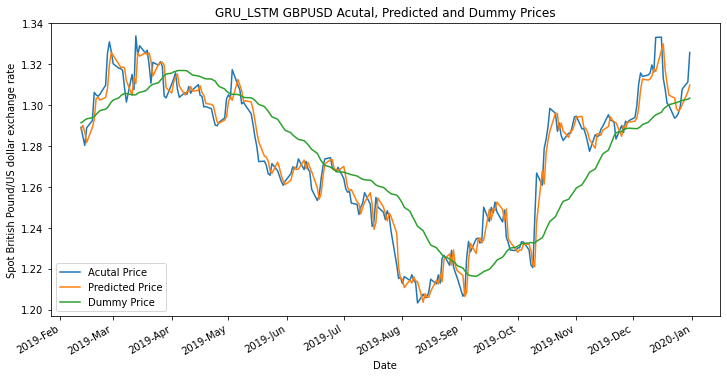

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

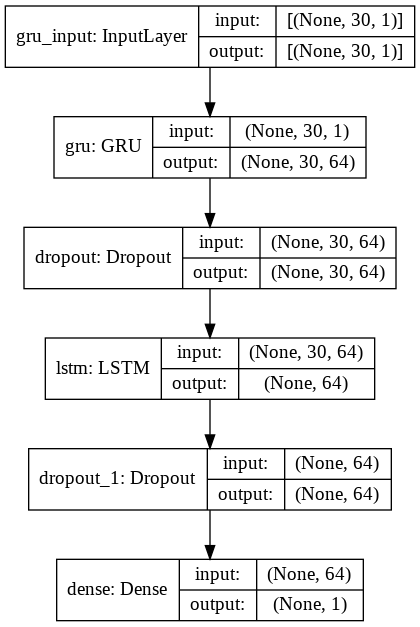

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.002555653740741004
RMSE:  0.05055347407192708
MAE:  0.03780665827400343
Dummy MSE:  0.02193382943864584
Dummy RMSE:  0.14810074084435176
Dummy MAE:  0.1194927932858967


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_GBPUSD/assets
